# Neural Style Transfer type Synthesis but with a VAE (Target Domain) and a triplet encoders

In [1]:
import scripts.init_gpu as init_gpu
import scripts.init_dataset as init_dataset
from scripts.triplet_functions import n_neurons
import pandas as pd


init_gpu.initialize_gpus()

locations = ['LOC1', 'LOC2']

print("Loading Dataset...")
# load the dataset
df = pd.read_csv(
    f"../dataset/processed/{locations[0]}-{locations[1]}-scaled-balanced.csv")

length = len(df.columns) - 2  # subtract the two label columns

# get train-test set
train_df, test_df, train_web_samples, test_web_samples = init_dataset.get_sample(
    df, locations, range(1500), 1200)

train_df.head()

2024-11-12 11:37:46.229311: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 11:37:46.235980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731371866.244092 3105335 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731371866.246518 3105335 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 11:37:46.254697: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  2
Loading Dataset...
Training Websites: [1309, 228, 51, 563, 501, 457, 285, 209, 1385, 1116, 178, 1209, 864, 65, 61, 191, 447, 476, 1034, 1232, 54, 1149, 407, 1466, 1330, 1436, 1490, 859, 451, 919, 1206, 569, 13, 326, 1429, 865, 696, 1468, 318, 440, 689, 1492, 189, 778, 198, 735, 704, 1236, 541, 88, 940, 1098, 255, 775, 161, 1130, 600, 1287, 1266, 740, 1182, 393, 142, 93, 1354, 466, 592, 163, 1482, 206, 1456, 1462, 928, 1301, 747, 333, 758, 727, 429, 1372, 546, 1399, 1327, 146, 1247, 1300, 350, 1093, 1495, 334, 946, 777, 552, 1310, 1140, 449, 1402, 664, 114, 469, 1486, 646, 821, 548, 135, 432, 1161, 644, 435, 1342, 1022, 810, 1316, 939, 292, 542, 1493, 505, 1478, 1103, 538, 1197, 877, 1195, 817, 741, 1404, 283, 1043, 1010, 186, 96, 224, 313, 1285, 327, 1487, 1221, 130, 788, 781, 1220, 958, 1083, 514, 1133, 23, 234, 1099, 1419, 1312, 1463, 1498, 601, 890, 323, 929, 6, 539, 1025, 365, 1039, 217, 1280, 611, 1308, 1338, 1415, 1477, 1366, 765, 330, 1104, 1086, 1, 1226, 

/home/asil0892/doh_traffic_analysis/code/scripts/init_dataset.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.sort_values(by=["Location"], inplace=True)


,Location,Website,0,1,2,3,4,5,6,7,...,116,117,118,119,120,121,122,123,124,125
0,LOC1,0,-1.086861,0.690199,0.647933,0.201517,0.207139,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604
1,LOC1,1005,1.095547,-1.585943,0.647933,0.343653,0.207139,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604
2,LOC1,1005,1.095547,0.780047,-1.972790,0.343653,0.207139,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604
3,LOC1,1005,-1.086861,0.690199,0.647933,0.343653,0.207139,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604
4,LOC1,1005,1.095547,0.780047,0.183501,-0.828965,-2.083179,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604


In [3]:
import tensorflow as tf
from scripts.train_vae import VAE, Sampling

# load models
vae_model = tf.keras.models.load_model("../models/vae/LOC2-e400-mse1-kl0.01.keras", custom_objects={'VAE': VAE, 'Sampling': Sampling})
web_model = tf.keras.models.load_model(f"../models/website/{locations[0]}-{locations[1]}-baseGRU-epochs100-train_samples1200-triplet_samples5-domain_invariant-l1.keras")
location_classifier = tf.keras.models.load_model(f"../models/classification/location/dense.keras")

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_29. Received: the structure of inputs=['*', '*']
  warnings.warn(


In [4]:
# web content classifier model for debugging and analysing only: DO NOT USE FOR A LOSS FUNCTION
# load classifier corresponding to the triplet model
import joblib
from sklearn.preprocessing import LabelEncoder
from scripts.classification import preprocess_data_for_web_classification

knn_web_classifier = joblib.load("../models/classification/website/KNN-TripletEpochs200-Samples5-DomainInvariant.pkl")


# synthesize data

In [149]:
import numpy as np
import tensorflow as tf

class TrafficSynthesisModel(tf.keras.Model):
    def __init__(self, vae_model, website_model, location_classifier, v_source, target_location):
        super(TrafficSynthesisModel, self).__init__()
        
        # Models
        self.vae_model = vae_model
        self.website_model = website_model
        self.location_classifier = location_classifier

        # Fix the weights of the other models
        self._freeze_models()

        # Data and embeddings
        self.v_synth = v_source
        self.website_embedding = website_model(v_source)

        # print("Initializing...")
        # v_initial = tf.random.uniform(shape=(1, vae_model.latent_dim), minval=-2, maxval=2)
        # while(self.get_euclidean_distance(v_initial, self.website_embedding[0]) > 0.01):
        v_initial = tf.random.uniform(shape=(1, vae_model.latent_dim), minval=-1, maxval=1)

        self.latent_embedding = tf.Variable(v_initial)
        
        # Location target
        self.target_location = self._set_target_location(target_location)

        # Hyperparameters
        self.epsilon = 1e-6  # To avoid division by zero in log calculations
        self.max_annealing_epoch = 500
        self.max_reg_weight = 0.01
        self.max_website_weight = 1

    def _freeze_models(self):
        self.website_model.trainable = False
        self.location_classifier.trainable = False
        self.vae_model.trainable = False

    def _set_target_location(self, target_location):
        if target_location == 'LOC1':
            return tf.constant(0.0, dtype=tf.float32)
        elif target_location == 'LOC2':
            return tf.constant(1.0, dtype=tf.float32)
        else:
            raise Exception('Invalid Location')

    def compute_latent_prior_loss(self, z):
        mean_loss = tf.reduce_mean(tf.square(z))
        magnitude_loss = tf.abs(tf.reduce_sum(tf.square(z)) - tf.cast(tf.shape(z)[1], tf.float32))
        return mean_loss, magnitude_loss
    
    def get_regularization_weight(self, epoch):
        return self.max_reg_weight * min(epoch / self.max_annealing_epoch, 1.0)
    
    def get_website_weight(self, epoch):
        return self.max_website_weight * min(epoch / self.max_annealing_epoch, 1.0)

    def get_euclidean_distance(self, vector_a, vector_b):
        return tf.reduce_mean(tf.square(vector_a - vector_b))

    def compute_losses(self, epoch):
        """Calculate and return individual loss components as a dictionary."""
        self.v_synth = self.vae_model.decode(self.latent_embedding)

        losses = {}

        synth_triplet_embedding = self.website_model(self.v_synth)
        
        # Website reconstruction loss
        losses["website_loss"] = self.get_euclidean_distance(self.website_embedding[0], synth_triplet_embedding[0])

        # Synthesized trace location classification loss
        predicted_location = tf.clip_by_value(self.location_classifier(self.v_synth)[0][0], self.epsilon, 1 - self.epsilon)
        losses["classification_loss"] = - (self.target_location * tf.math.log(predicted_location) + (1 - self.target_location) * tf.math.log(1 - predicted_location))

        # Prior losses
        prior_mean_loss, prior_magnitude_loss = self.compute_latent_prior_loss(self.latent_embedding)
        losses["prior_mean_loss"] = prior_mean_loss
        losses["prior_magnitude_loss"] = prior_magnitude_loss

        # Compute total loss by summing all loss components
        total_loss = (
            # 0.01 * losses['classification_loss'] +
            losses['website_loss'] 
            # 0.1 * losses['prior_mean_loss']
            # losses['prior_magnitude_loss']
        )
        return total_loss, losses

    def train_step(self, epoch):
        with tf.GradientTape() as tape:
            total_loss, losses = self.compute_losses(epoch)
        
        gradients = tape.gradient(total_loss, [self.latent_embedding])
        self.optimizer.apply_gradients(zip(gradients, [self.latent_embedding]))
        
        return total_loss, losses

    def fit(self, epochs=1000, lr=0.01):
        self.optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        
        for epoch in range(epochs):
            total_loss, losses = self.train_step(epoch)

            # TODO: Implement early stop based on some critieria
            # if (losses["latent_classification_loss"] <= 1e-2) or (losses["l2_loss"] <= 0.1):
            #     print(f"Early stopping triggered at epoch {epoch}. Loss: {total_loss.numpy()}")
            #     print(f"\tLosses: {losses}")
            #     break

            if epoch % 100 == 0:
                float_losses = {k: v.numpy() for k, v in losses.items()}
                print(f"Epoch {epoch}, Total Loss: {total_loss.numpy()}")
                print(f"\tLosses: {float_losses}")
        
        return self.v_synth.numpy(), self.latent_embedding.numpy(), losses["classification_loss"].numpy()

In [157]:
import random
random_seed = 42
target_location = 'LOC2'
source_location = 'LOC1'
synthesized_vectors = []
synth_latent_embeddings = []

target_website = 8
target_data = test_df[(test_df['Website'] == target_website) & (test_df['Location'] == target_location)].iloc[:, 2:].to_numpy()

_, _, _, _, le = preprocess_data_for_web_classification(test_df, source_location, target_location) 

i = 0
num_samples = 10
while i != num_samples:
    print(f"{i+1} of {num_samples}...")


    source_trace = test_df[(test_df['Location'] == source_location) & (
        test_df['Website'] == target_website)].iloc[:, 2:].sample(random_state=random_seed)

    source_trace = source_trace.to_numpy().reshape(1, length, 1)

    # initialize model
    print("Initializing TSM Model...")
    tsm_model = TrafficSynthesisModel(vae_model, web_model, location_classifier, source_trace, target_location)
    # synthesize
    epochs = 5000
    lr = 0.1
    
    print("Synthesizing Trace...")
    synthesized_vector, synth_z, location_trace_classification_loss = tsm_model.fit(epochs=epochs, lr=lr)

    # if not a good synthesis: Based on location classification
    predicted_website = le.classes_[knn_web_classifier.predict(web_model(synthesized_vector.reshape(1, length)))[0]]
    print(f"Predicted: {predicted_website}, Target: {target_website}")
    # if (location_trace_classification_loss > 0.4) or (predicted_website != target_website):
    #     print("Neglecting this one, not a good synthesis...")
    #     continue
    
    synthesized_vectors.append(synthesized_vector)
    synth_latent_embeddings.append(synth_z)
    i += 1

synth_latent_embeddings = np.array(synth_latent_embeddings).reshape(num_samples, vae_model.latent_dim)
synthesized_vectors = np.array(synthesized_vectors).reshape(num_samples, length)

1 of 10...
Initializing TSM Model...
Synthesizing Trace...
Epoch 0, Total Loss: 0.012898003682494164
	Losses: {'website_loss': 0.012898004, 'classification_loss': 0.3443667, 'prior_mean_loss': 0.2511111, 'prior_magnitude_loss': 23.964445}
Epoch 100, Total Loss: 0.008802950382232666
	Losses: {'website_loss': 0.00880295, 'classification_loss': 0.47128016, 'prior_mean_loss': 0.25898048, 'prior_magnitude_loss': 23.712624}
Epoch 200, Total Loss: 0.007906992919743061
	Losses: {'website_loss': 0.007906993, 'classification_loss': 0.40826306, 'prior_mean_loss': 0.2629099, 'prior_magnitude_loss': 23.586884}
Epoch 300, Total Loss: 0.0077288271859288216
	Losses: {'website_loss': 0.007728827, 'classification_loss': 0.49213937, 'prior_mean_loss': 0.26481026, 'prior_magnitude_loss': 23.526072}
Epoch 400, Total Loss: 0.007620749529451132
	Losses: {'website_loss': 0.0076207495, 'classification_loss': 0.51781964, 'prior_mean_loss': 0.26633197, 'prior_magnitude_loss': 23.477377}
Epoch 500, Total Loss: 0.

# Analyzing the synthesized data

### Finding the actual nearest neighbour to the synthesized latent embedding

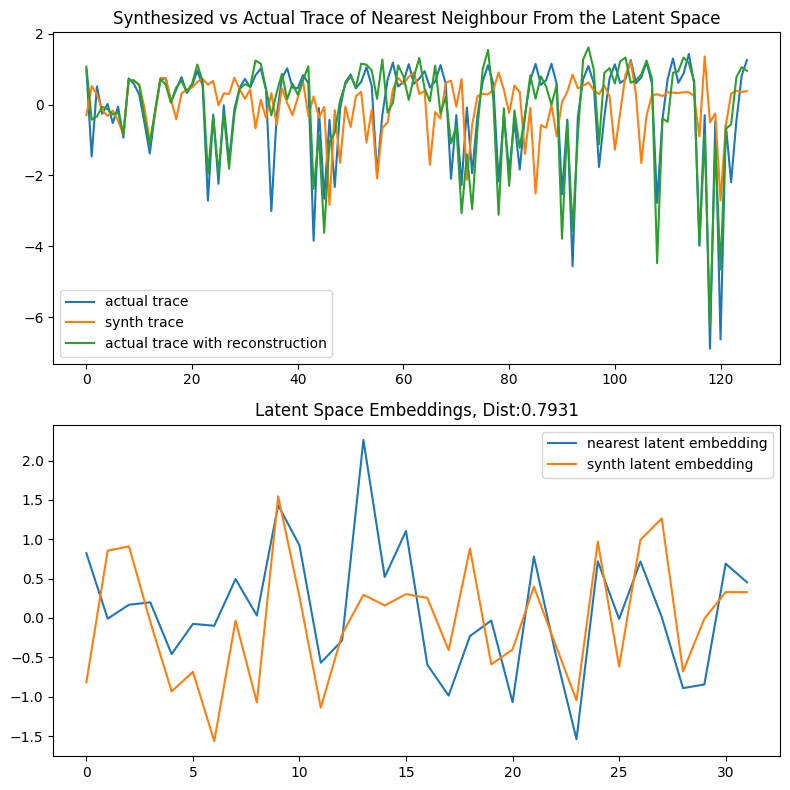

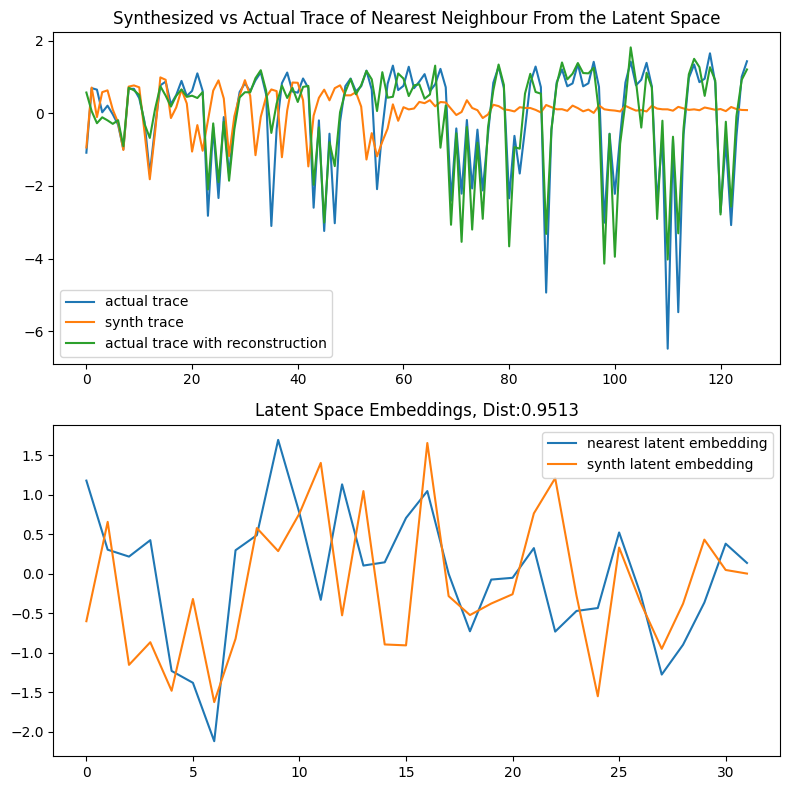

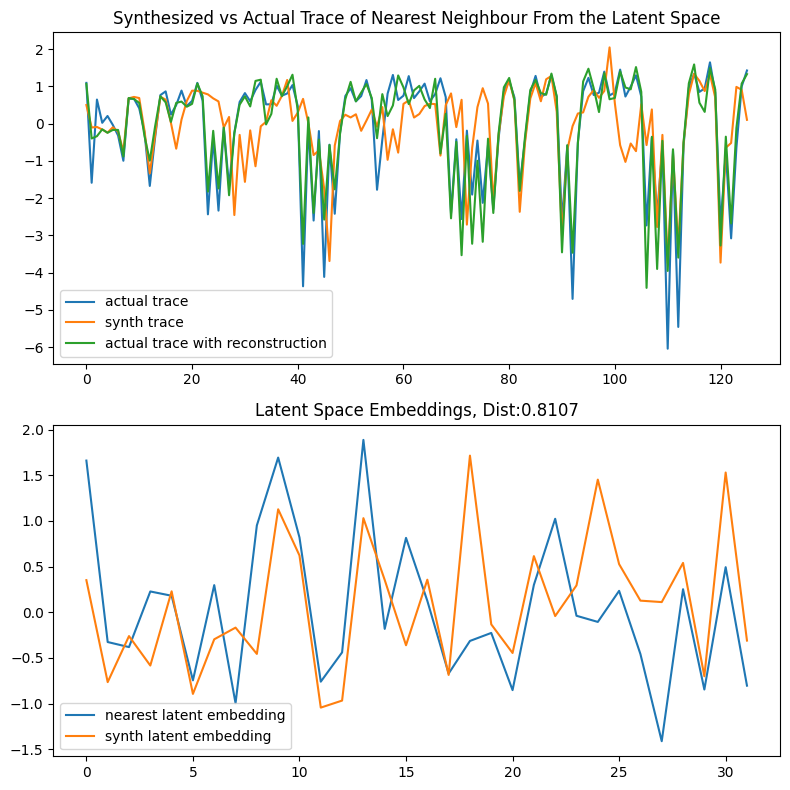

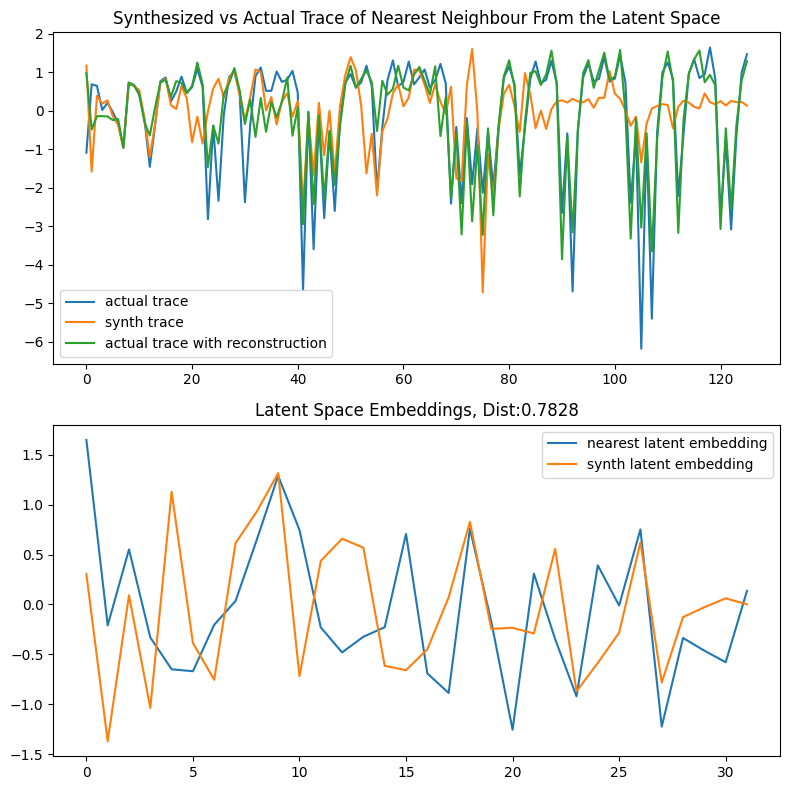

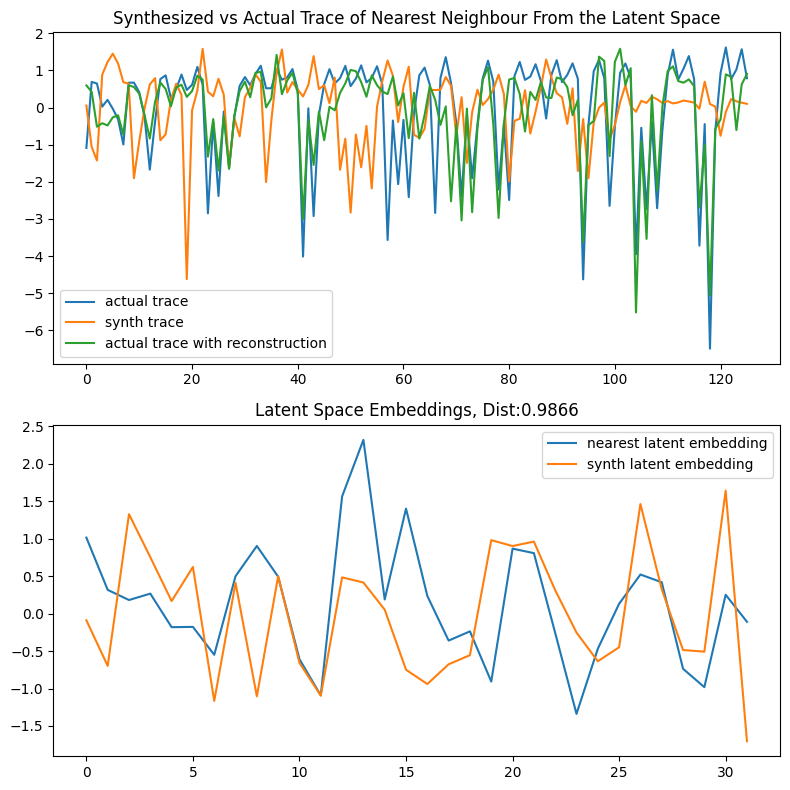

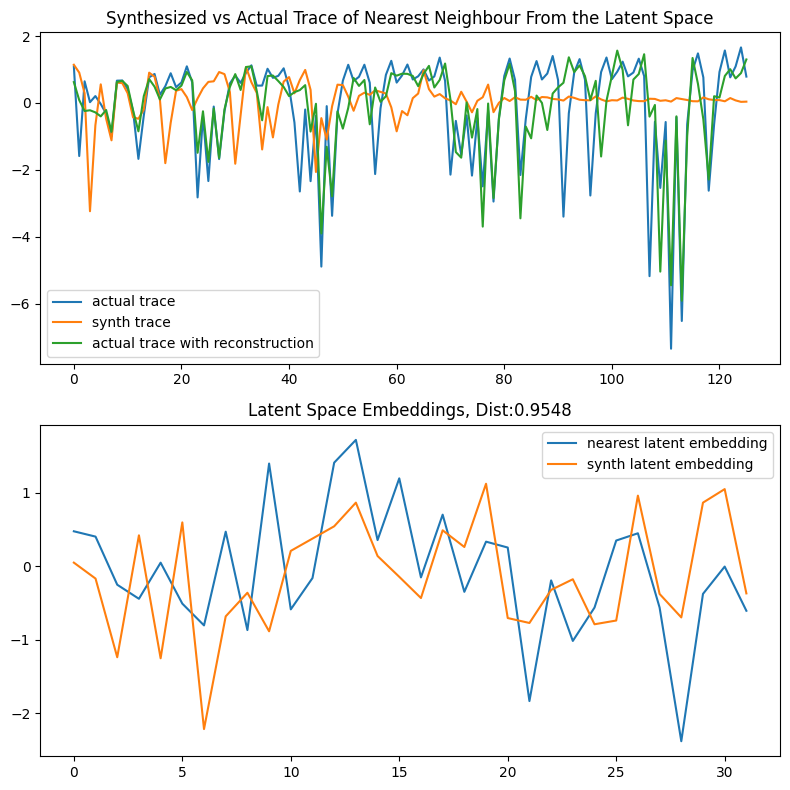

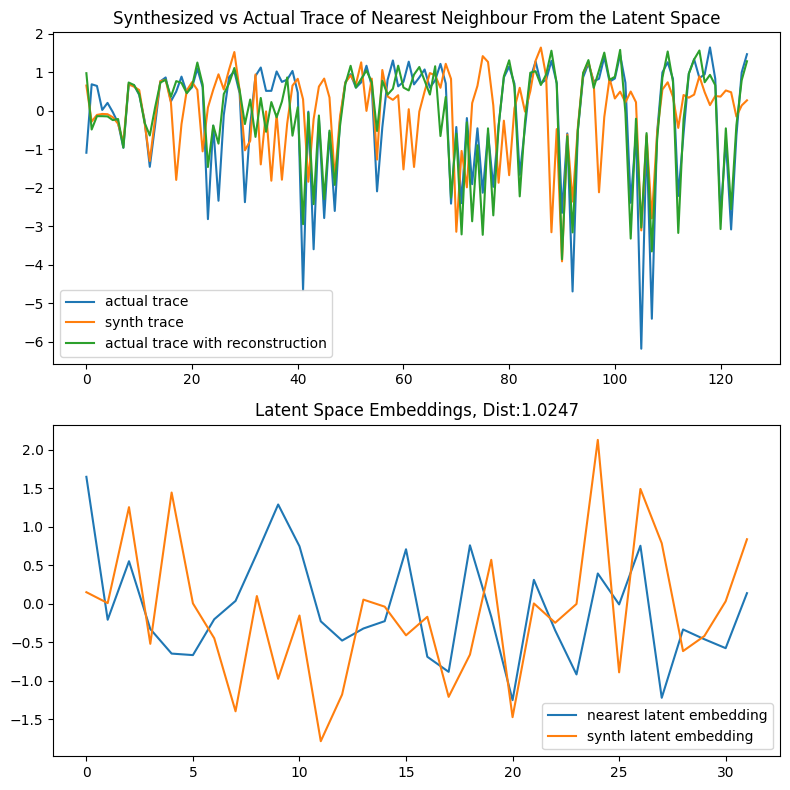

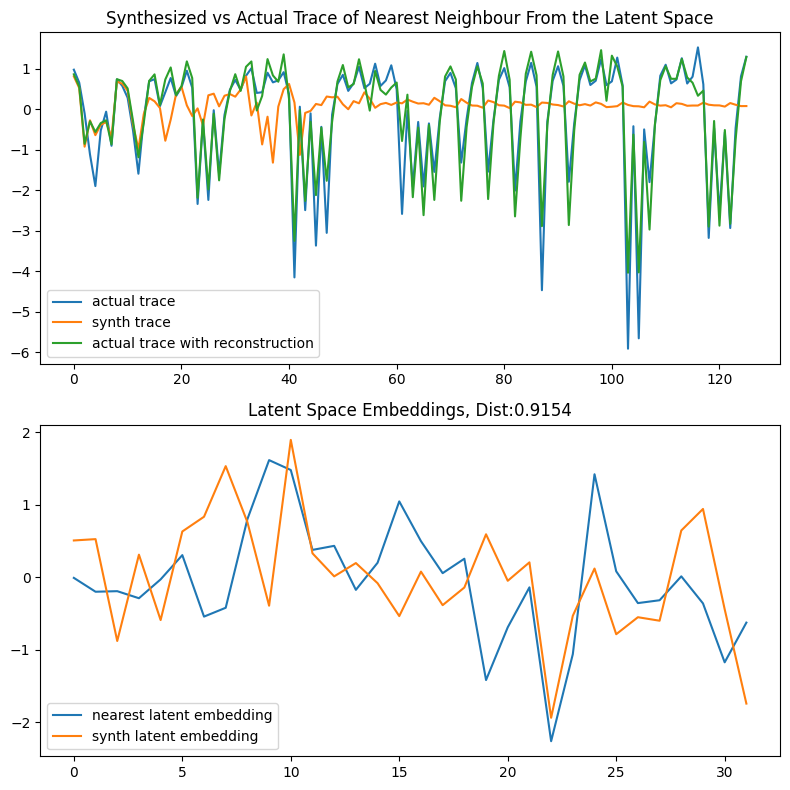

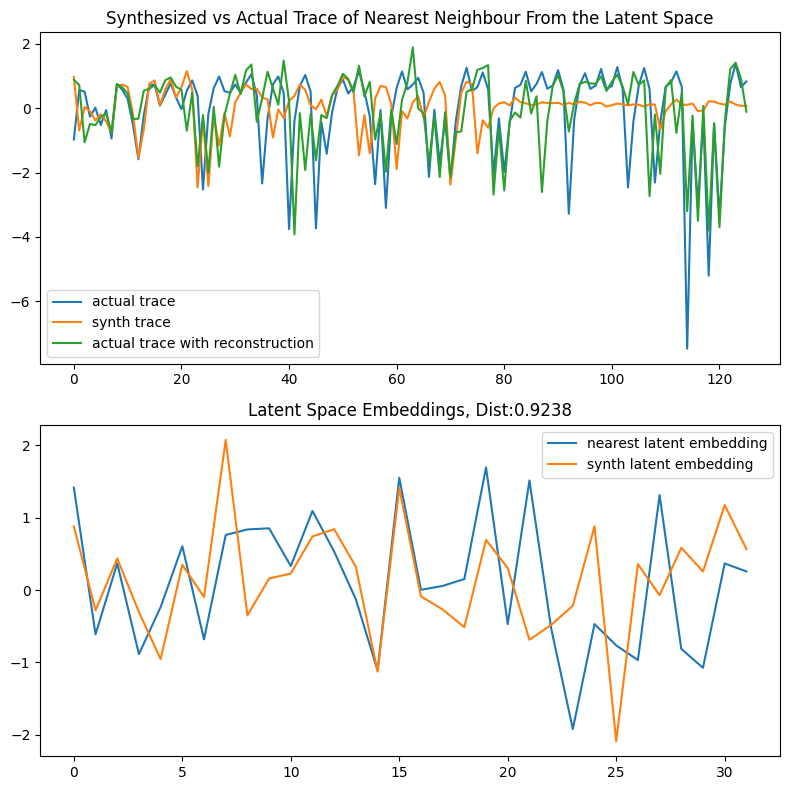

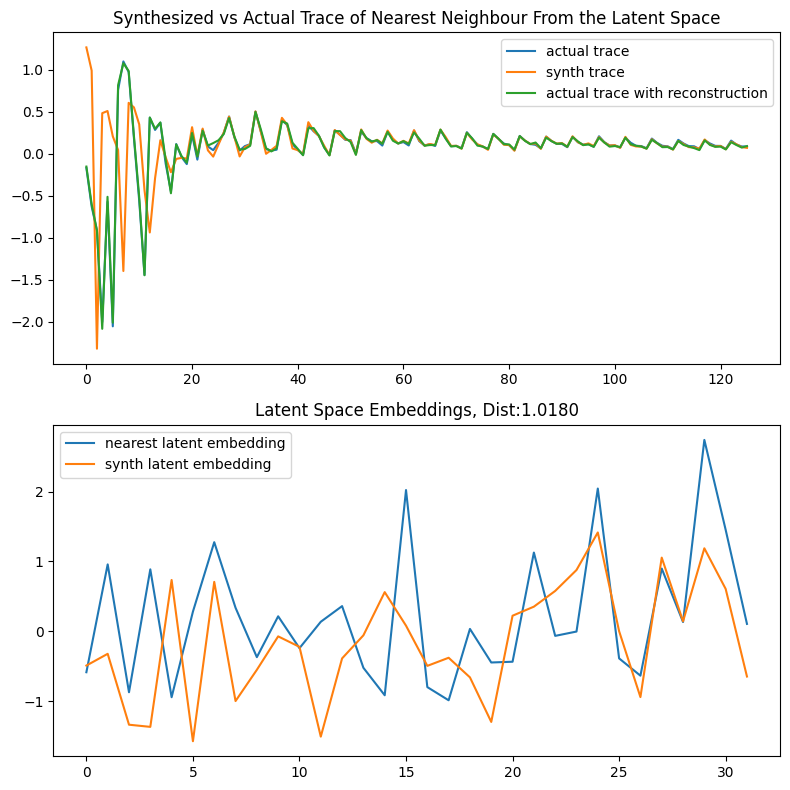

In [163]:
# Finding nearest neighbour to the traversed latent vector and comparing the reconstructions
import matplotlib.pyplot as plt
_, _, target_latent_embeddings = vae_model.encode(target_data)

for i in range(num_samples):
    z = synth_latent_embeddings[i]
    synth_trace = synthesized_vectors[i]
    # Compute Euclidean distances from `z` to each embedding in `embeddings_set`
    distances = tf.sqrt(tf.reduce_mean(tf.square(target_latent_embeddings - z), axis=1))

    # Find the index of the closest embedding
    nearest_neighbor_index = tf.argmin(distances)

    # Get the nearest neighbor embedding and its distance
    nearest_neighbor = target_latent_embeddings[nearest_neighbor_index]
    nearest_distance = distances[nearest_neighbor_index]

    actual_trace = target_data[nearest_neighbor_index]
    actual_trace_reconstructed_by_vae = vae_model.decode(nearest_neighbor.numpy().reshape(1, vae_model.latent_dim))[0]
    
    plt.figure(figsize=(8,8))
    plt.subplot(2, 1, 1)
    plt.plot(actual_trace, label='actual trace')
    plt.plot(synth_trace, label='synth trace')
    plt.plot(actual_trace_reconstructed_by_vae, label='actual trace with reconstruction')
    plt.title("Synthesized vs Actual Trace of Nearest Neighbour From the Latent Space")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(nearest_neighbor, label='nearest latent embedding')
    plt.plot(z, label='synth latent embedding')
    plt.legend()
    plt.title(f"Latent Space Embeddings, Dist:{nearest_distance:.4f}")
    plt.tight_layout()
    plt.show()
    plt.close()
    

# Website Classification: Does the synthesized triplet embedding belong to the correct class?

In [164]:
y_pred_actual_target = knn_web_classifier.predict(web_model(target_data))
for i in range(len(target_data)):
    predicted_website = le.classes_[y_pred_actual_target[i]]
    print(f"Actual Website: {target_website}, Predicted Website for Real Traffic: {predicted_website}")


y_pred_synth_arr = knn_web_classifier.predict(web_model(synthesized_vectors))
for i in range(num_samples):
    predicted_website = le.classes_[y_pred_synth_arr[i]]
    print(f"\n\nActual Website: {target_website}, Predicted Website for synthesized traffic: {predicted_website}")

Actual Website: 8, Predicted Website for Real Traffic: 8
Actual Website: 8, Predicted Website for Real Traffic: 8
Actual Website: 8, Predicted Website for Real Traffic: 8
Actual Website: 8, Predicted Website for Real Traffic: 8
Actual Website: 8, Predicted Website for Real Traffic: 8
Actual Website: 8, Predicted Website for Real Traffic: 8
Actual Website: 8, Predicted Website for Real Traffic: 8
Actual Website: 8, Predicted Website for Real Traffic: 8
Actual Website: 8, Predicted Website for Real Traffic: 8
Actual Website: 8, Predicted Website for Real Traffic: 8
Actual Website: 8, Predicted Website for Real Traffic: 8
Actual Website: 8, Predicted Website for Real Traffic: 8
Actual Website: 8, Predicted Website for Real Traffic: 8
Actual Website: 8, Predicted Website for Real Traffic: 8
Actual Website: 8, Predicted Website for Real Traffic: 132
Actual Website: 8, Predicted Website for Real Traffic: 8
Actual Website: 8, Predicted Website for Real Traffic: 8
Actual Website: 8, Predicted 

# Plotting the target distribution of traces and synthesized traces

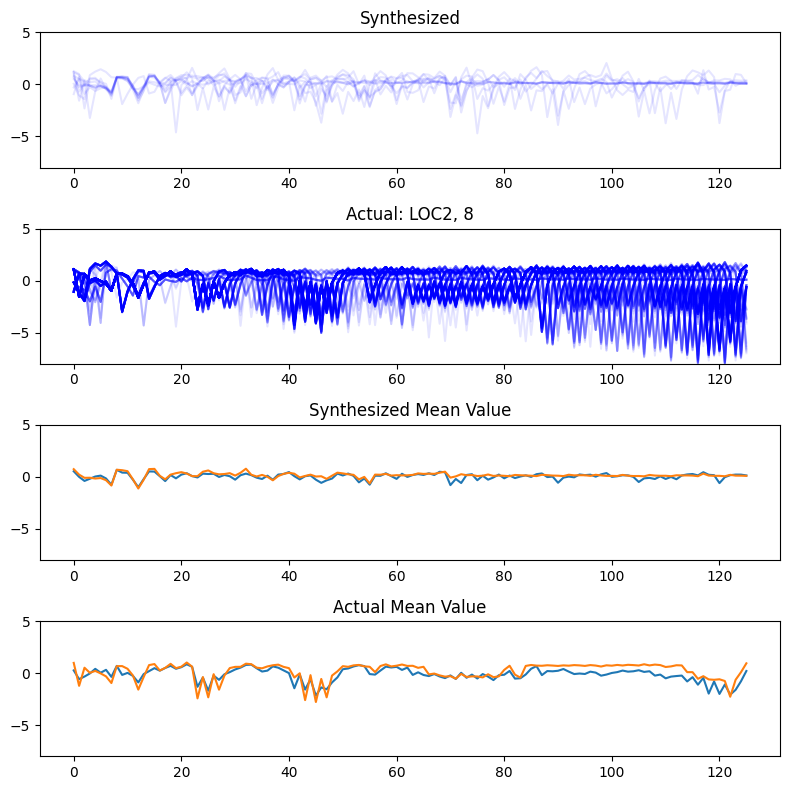

In [165]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 8))
plt.subplot(4,1,1)
for i in range(num_samples):
    plt.plot(synthesized_vectors[i], alpha=0.1, c='b')
plt.title(f'Synthesized')
plt.ylim((-8, 5))
plt.subplot(4,1,2)
for i in range(200):
    plt.plot(target_data[i], alpha=0.1, c='b')
plt.title(f"Actual: {target_location}, {target_website}")
plt.ylim((-8, 5))

plt.subplot(4, 1, 3)
plt.plot(np.mean(np.array(synthesized_vectors).reshape(num_samples, length), axis=0))
plt.plot(np.median(np.array(synthesized_vectors).reshape(num_samples, length), axis=0))
plt.title("Synthesized Mean Value")
plt.ylim((-8, 5))


plt.subplot(4, 1, 4)
plt.plot(target_data.mean(axis=0))
plt.plot(np.median(target_data, axis=0))
plt.title("Actual Mean Value")
plt.ylim((-8, 5))
plt.tight_layout()
plt.show()



# Latent space visualization

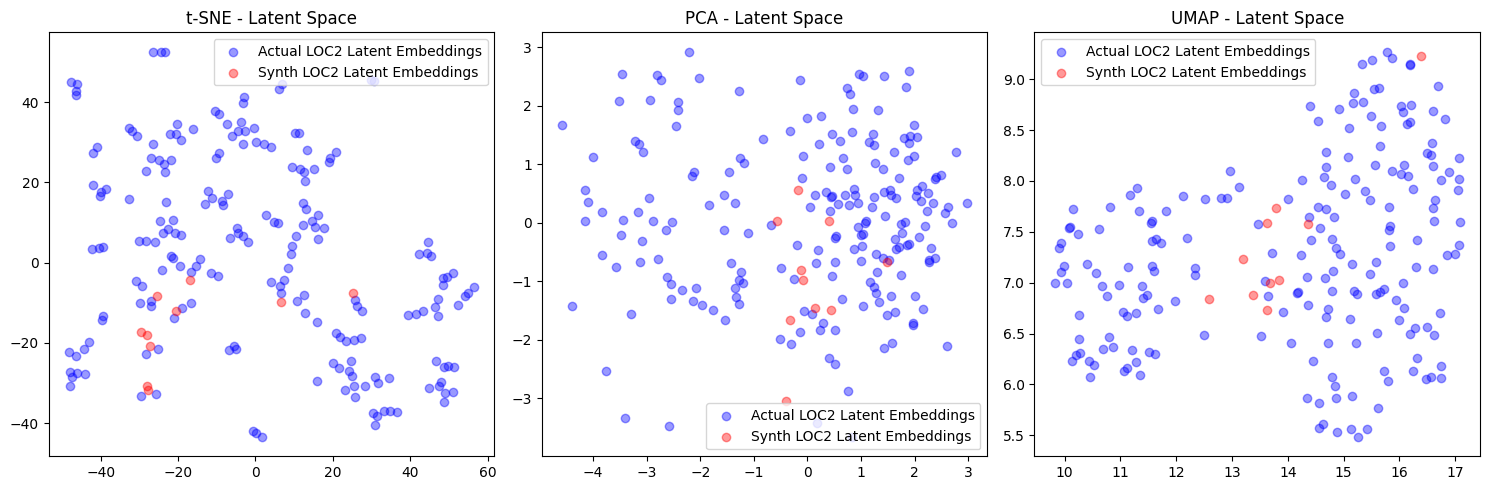

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import random
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

reducers = {'t-SNE': TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3), 'PCA': PCA(n_components=2), 'UMAP': umap.UMAP()}



_, _, target_latent_embeddings = vae_model.encode(target_data)
_, _, synth_latent_embeddings = vae_model.encode(np.array(synthesized_vectors).reshape(num_samples, length))

combined_embeddings = np.concatenate((target_latent_embeddings, synth_latent_embeddings), axis=0)


def plt_scatter_location(embedding, label:str, color: str):    
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        alpha=0.4,
        label = label,
        c=color
    )

plt.figure(figsize=(15, 5))
i = 1
for reducer_name, reducer in reducers.items():
    combined_embeddings_reduced = reducer.fit_transform(combined_embeddings)

    # Separate embeddings
    target_embeddings_reduced = combined_embeddings_reduced[:len(target_latent_embeddings)]
    synth_embeddings_reduced = combined_embeddings_reduced[len(target_latent_embeddings): len(target_latent_embeddings) + len(synth_latent_embeddings)]

    plt.subplot(1, len(reducers), i)
    plt_scatter_location(target_embeddings_reduced, 'Actual LOC2 Latent Embeddings', 'b')
    plt_scatter_location(synth_embeddings_reduced, 'Synth LOC2 Latent Embeddings', 'r')
    i += 1
    plt.legend()
    plt.tight_layout()
    plt.title(f"{reducer_name} - Latent Space")
plt.show()


# Triplet Embedding Visualization

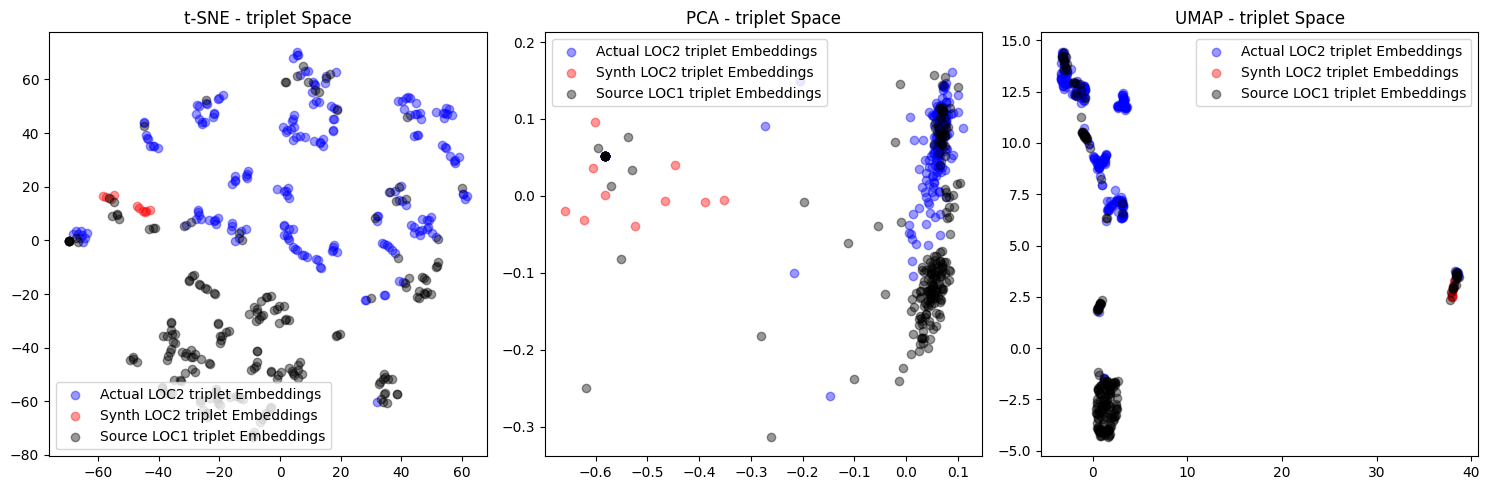

In [167]:
source_traces = test_df[(test_df['Location'] == source_location) & (
        test_df['Website'] == target_website)].iloc[:, 2:].to_numpy()


target_triplet_embeddings = web_model(target_data)
synth_triplet_embeddings = web_model(np.array(synthesized_vectors).reshape(num_samples, length))
source_triplet_embeddings = web_model(source_traces)

combined_embeddings = np.concatenate((target_triplet_embeddings, synth_triplet_embeddings, source_triplet_embeddings), axis=0)


def plt_scatter_location(embedding, label:str, color: str):    
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        alpha=0.4,
        label = label,
        c=color
    )

plt.figure(figsize=(15, 5))
i = 1
for reducer_name, reducer in reducers.items():
    combined_embeddings_reduced = reducer.fit_transform(combined_embeddings)

    # Separate embeddings
    target_embeddings_reduced = combined_embeddings_reduced[:len(target_triplet_embeddings)]
    synth_embeddings_reduced = combined_embeddings_reduced[len(target_triplet_embeddings): len(target_triplet_embeddings) + len(synth_triplet_embeddings)]
    source_embeddings_reduced = combined_embeddings_reduced[len(target_triplet_embeddings) + len(synth_triplet_embeddings): len(target_triplet_embeddings) + len(synth_triplet_embeddings) + len(source_triplet_embeddings)]

    plt.subplot(1, len(reducers), i)
    plt_scatter_location(target_embeddings_reduced, 'Actual LOC2 triplet Embeddings', 'b')
    plt_scatter_location(synth_embeddings_reduced, 'Synth LOC2 triplet Embeddings', 'r')
    plt_scatter_location(source_embeddings_reduced, 'Source LOC1 triplet Embeddings', 'k')
    i += 1
    plt.legend()
    plt.tight_layout()
    plt.title(f"{reducer_name} - triplet Space")
plt.show()
